<a href="https://colab.research.google.com/github/Cipe96/EEG-Recognition/blob/main/Analisi_dei_risultati.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**EEG Recognition: Analisi dei risultati**</font>
</br><font size=3>*Marco Cipollina, Riccardo Era*</font>


<p style="font-size:4px;" align="justify">In questo notebook vengono esposti e discussi i risultati ottenuti nelle diverse fasi del progetto.</p>

<p style="font-size:4px;" align="justify">Tutte le singole accuratezze riportare sono il frutto della media di due classificazioni inerenti un determiato setup.</p>

<font size=4>**Indice:**</font>
*   [Import librerie e montaggio Drive](#1)
*   [Grid Search per il pre-processing](#2)
*   [Grid Search per gli iperparametri del modello](#3)
*   [Risultati definitivi dei vari modelli](#4)
*   [XAI](#5)
*   [Conclusioni e rispettive domande aperte](#6)

---
<a name="1"></a>
# **Import librerie e montaggio Drive**

In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

In [ ]:
#@title Percorso della cartella del progetto su Google Drive:

#@markdown Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:

%%capture
drive.mount('/content/drive', force_remount=True)

# elimina la cartella sample_data creata automaticamente
! rm -r /content/sample_data
PERCORSO_DRIVE = "EEG Recognition" #@param {type:"string"}

PERCORSO_DRIVE = '/content/drive/MyDrive/' + PERCORSO_DRIVE
sys.path.append(PERCORSO_DRIVE)

---
<a name="2"></a>
# **Grid Search per il pre-processing**

Il preprocessamento che abbiamo tenuto costante, in quanto reputato utile a priori, è il seguente:

*   Segmentazione in epoche: i campioni sono segmentati in finestre di 1.5 secondi senza sovrapposizione.

*   Conversione da float64 a float32: per ottenere un guadagno computazionale senza perdere dati rilevanti.

*   Normalizzazione dei dati: per ottenere una distribuzione uniforme tra i canali EEG e una stabilità maggiore in fase di modellazione


Il primo esperimento che abbiamo fatto è stato eseguito sul filtro broadband (1-80 Hz), in modo tale da permetterci una visione generale su quasi tutti i dati disponibili. Per questa banda sono state ottenute inizialmente 2 sole varianti dello stesso preprocessamento:

*   Normale: con il preprocessamento citato sopra
*   PCA: con l'aggiunta della Principal Component Analysis a 37 componenti

Di seguito il confronto:



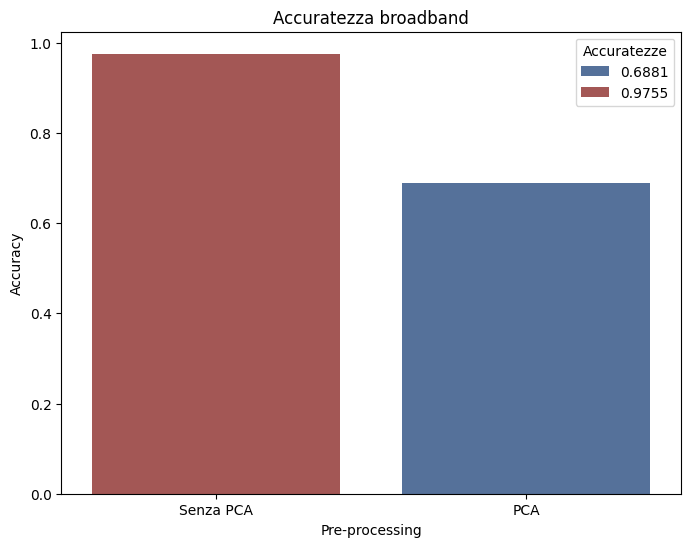

In [ ]:
#@title Analisi utilità PCA

# Varianti e risultati
labels = ['Senza PCA', 'PCA']
accuracies = [0.9755, 0.6881]
colori = ['#4a6fa5', '#b04a48']

# Creazione del DataFrame
data = {
    'Pre-processing': labels,
    'Accuracy': accuracies,
    'Colors': colori
}

df = pd.DataFrame(data)
# Creiamo un grafico a barre
plt.figure(figsize=(8, 6))
sns.barplot(data = df, x='Pre-processing', y='Accuracy', hue = "Accuracy", palette=colori)


plt.legend(title='Accuratezze')
plt.title("Accuratezza broadband")
plt.show()


Si vede subito dal grafico quanto la PCA influenzi negativamente i risultati ottenuti. Nel caso di un dataset abbastanza maneggevole come il nostro, non è stato nemmeno ottenuto un trade-off significativo in termini di tempi di addestramento. Per questo motivo da qui in poi la PCA è stata scartata.

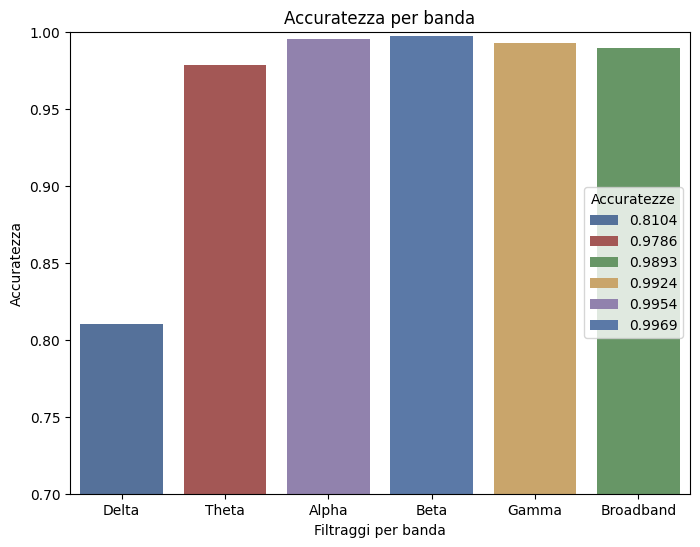

In [ ]:
#@title Confronto fra bande

# Dizionario contenente le bande e le relative accuratezze
bande = {
    'Delta': 0.8104,
    'Theta': 0.9786,
    'Alpha': 0.9954,
    'Beta': 0.9969,
    'Gamma': 0.9924,
    'Broadband': 0.9893,
}

colori = ['#4a6fa5', '#b04a48', '#5f9e5e', '#d8a95c', '#8f7bb4', '#4e76b4']

# Estrazione dei dati dal dizionario per le etichette e i valori di accuratezza
labels = list(bande.keys())
accuracies = list(bande.values())

data = {
    'Pre-processing': labels,
    'Accuracy': accuracies
}

df = pd.DataFrame(data)
# Creiamo un grafico a barre
plt.figure(figsize=(8, 6))
sns.barplot(data = df, x='Pre-processing', y='Accuracy', hue = "Accuracy", palette=colori)
plt.legend(title='Accuratezze', loc='center right')
plt.xlabel("Filtraggi per banda")
plt.ylabel("Accuratezza")
plt.title("Accuratezza per banda")
plt.ylim(0.7, 1)

plt.show()

Da entrambi i grafici si nota subito come, perlomeno nella run 01 del dataset, l'onda delta sia meno significativa rispetto a tutte le altre. La theta ancora soffre di qualche mancanza, mentre le bande alpha, beta, gamma e broadband portano tutte ottimi risultati.

Visto che le frequenze oltre la banda Gamma apparentemente non hanno portato nessun valore aggiunto, abbiamo pensato di provare ad utilizzare due nuove bande di frequenza:

*   ABG: (4-40 Hz)
*   Personalizzata (1-40 Hz)



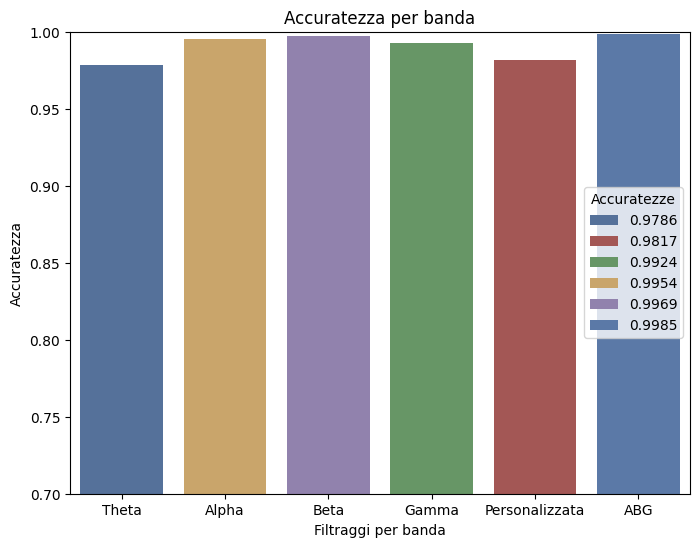

In [ ]:
#@title Confronto fra bande

# Dizionario contenente le bande e le relative accuratezze
bande = {
    'Theta': 0.9786,
    'Alpha': 0.9954,
    'Beta': 0.9969,
    'Gamma': 0.9924,
    'Personalizzata': 0.9817,
    'ABG': 0.9985
}

colori = ['#4a6fa5', '#b04a48', '#5f9e5e', '#d8a95c', '#8f7bb4', '#4e76b4']

# Estrazione dei dati dal dizionario per le etichette e i valori di accuratezza
labels = list(bande.keys())
accuracies = list(bande.values())

data = {
    'Pre-processing': labels,
    'Accuracy': accuracies
}

df = pd.DataFrame(data)
# Creiamo un grafico a barre
plt.figure(figsize=(8, 6))
sns.barplot(data = df, x='Pre-processing', y='Accuracy', hue = "Accuracy", palette=colori)
plt.legend(title='Accuratezze', loc='center right')
plt.xlabel("Filtraggi per banda")
plt.ylabel("Accuratezza")
plt.title("Accuratezza per banda")
plt.ylim(0.7, 1)
plt.show()

La banda ABG è l'unica che permette di superare la soglia del 99%.
Per questo motivo tutti i prossimi esperimenti saranno fatti utilizzando la banda ABG con dati segmentati, normalizzati e ridotti a float32.

---
<a name="3"></a>
# **Grid Search per gli iperparametri del modello**



In [ ]:
#@title Importazione dei risultati ottenuti e creazione Datframe
filtri = [
    16, 16, 16, 16, 16, 16,
    32, 32, 32, 32, 32, 32,
    64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
    128, 128
    ]

dropout = [
    0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
    0.6, 0.6, 0.6, 0.6, 0.3, 0.3,
    0.3, 0.3, 0.6, 0.6, 0.3, 0.3, 0.15, 0.15, 0, 0,
    0.15, 0.15
    ]

strati = [
    3, 3, 2, 2, 1, 1,
    2, 2, 1, 1, 2, 2,
    2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
    1, 1
]

only_separable = [
    False, True, False, True, False, True,
    False, True, False, True, False, True,
    False, True, False, True, False, True, False, True, False, True,
    False, True
]

accuracies = [
    0.9083, 0.9266, 0.9327, 0.8884, 0.9618, 0.9725,
    0.9786, 0.9679, 0.9872, 0.9755, 0.9801, 0.9893,
    0.9939, 0.9924, 0.9924, 0.9862, 0.9924, 0.9878, 0.9969, 0.9924, 0.9954, 0.9862,
    0.9954, 0.9924
]

# Creazione del DataFrame
data = {
    'Filtri': filtri,
    'Dropout': dropout,
    'Strati': strati,
    'Only_separable': only_separable,
    'Accuracy': accuracies
}

df = pd.DataFrame(data)

### Analisi dell'impatto degli strati
In questo grafico vediamo come, tenendo fissi i filtri a 16 e il dropout a 0.6, variano i risultati all'aumentare degli strati

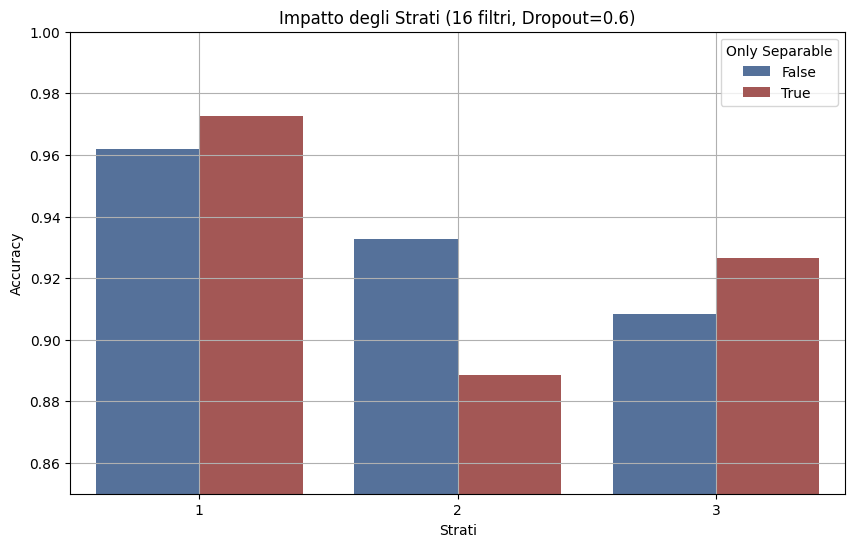

In [ ]:
#@title Barplot per l'impatto degli strati
# Filtriamo i dati per l'analisi dell'impatto degli strati: 16 filtri, dropout 0.6
df_fase1 = df[(df['Filtri'] == 16) & (df['Dropout'] == 0.6)]

colori = ['#4a6fa5', '#b04a48']

# Creazione del grafico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_fase1, x='Strati', y='Accuracy', hue='Only_separable', palette=colori)
plt.title('Impatto degli Strati (16 filtri, Dropout=0.6)')
plt.ylim(0.85, 1)
plt.legend(title='Only Separable')
plt.grid()
plt.show()

Da questo grafico a barre iniziamo a dedurre che un solo strato possa essere la scelta migliora, sopratutto valutando la leggerezza del modello.

### Aumento dei filtri
In questo grafico vediamo come, tenendo fissi i filtri a 32 e il dropout a 0.6, variano i risultati rispetto a prima e al variare di soli 2 strati

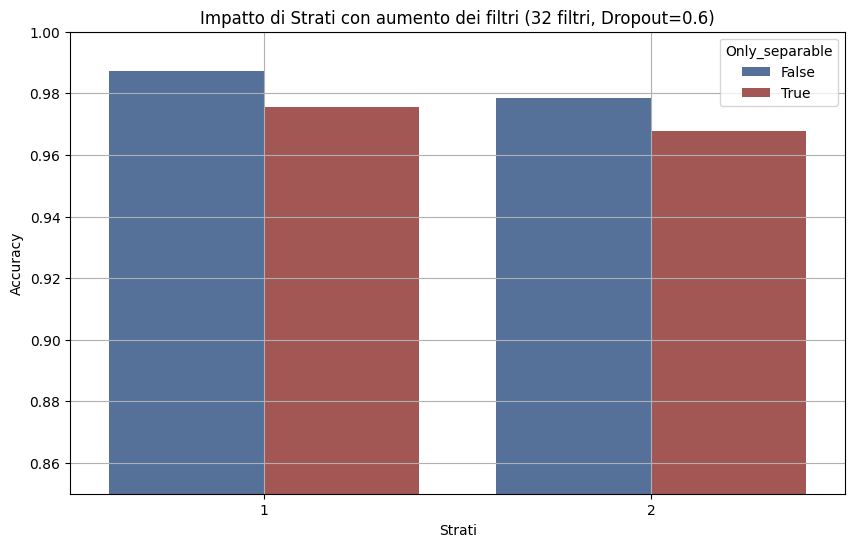

In [ ]:
# Filtriamo i dati per la Fase 2: 32 filtri, dropout 0.6
df_fase2 = df[(df['Filtri'] == 32) & (df['Dropout'] == 0.6)]

# Creazione del grafico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_fase2, x='Strati', y='Accuracy', hue='Only_separable', palette= colori)
plt.title('Impatto di Strati con aumento dei filtri (32 filtri, Dropout=0.6)')
plt.ylim(0.85, 1)
plt.grid()
plt.show()

Da questo grafico deduciamo che aumentare i filtri porta un miglioramento e confermiamo nuovamente un unico strato come miglire scelta

### Analisi al variare del Dropout con ulteriore aumento dei filtri
In questo grafico vediamo come, tenendo fissi i filtri a 64 ed un solo strato, variano i risultati rispetto al variare del dropout

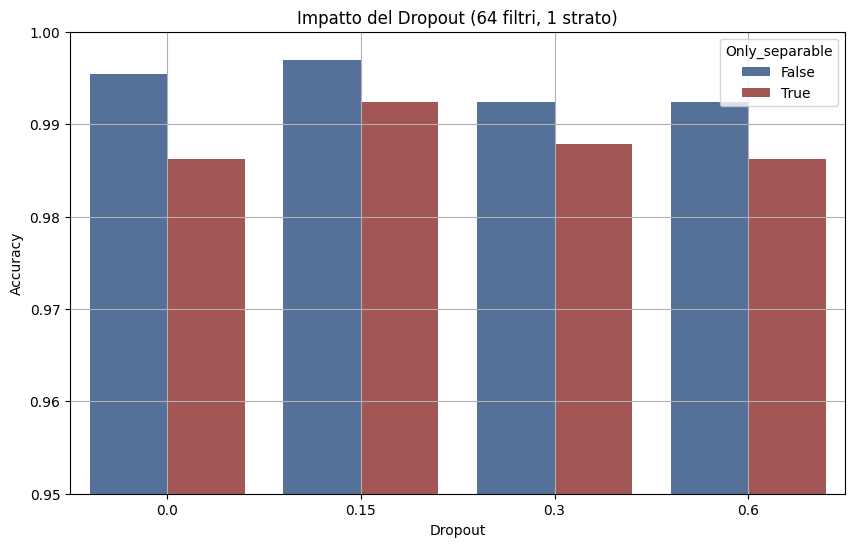

In [ ]:
# 64 filtri, uno strato e dropout variabile
df_fase3 = df[(df['Filtri'] == 64) & (df['Strati'] == 1)]

# Creazione del grafico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_fase3, x='Dropout', y='Accuracy', hue='Only_separable', palette= colori)
plt.title('Impatto del Dropout (64 filtri, 1 strato)')
plt.ylim(0.95, 1)
plt.grid()
plt.show()

Fissimao con migliore combinazione 64 filtri, droput pari a 0.15 e un solo strato

### Tentativo di ulteriore aumento dei filtri
Dopo aver fissato i migliori iperparametri proviamo ad aumentare ancora le prestazioni con l'aggiunta di altri filtri.

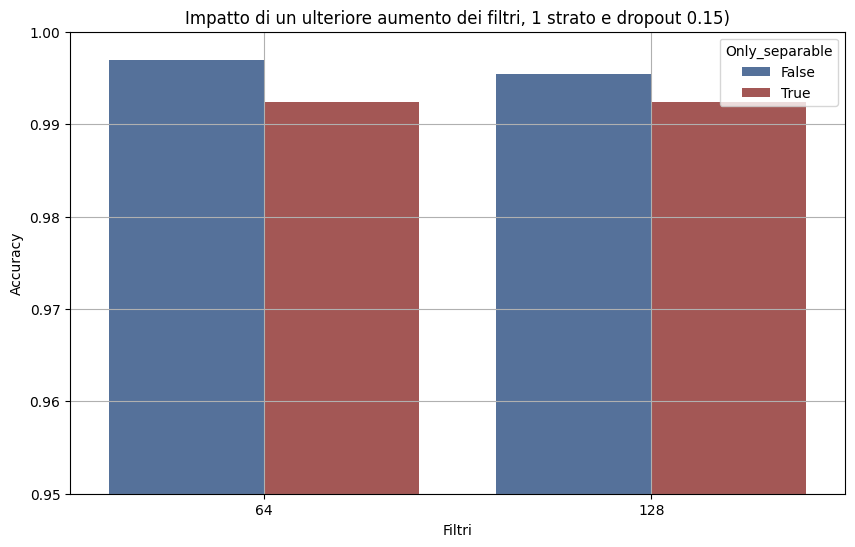

In [ ]:
# Filtriamo i dati per la Fase 4: 64e 128 filtri, dropout e strati fissi
df_fase4 = df[(df['Filtri'].isin([64, 128])) & (df['Strati'] == 1) & (df['Dropout'] == 0.15)]

# Creazione del grafico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_fase4, x='Filtri', y='Accuracy', hue='Only_separable', palette= colori)
plt.title('Impatto di un ulteriore aumento dei filtri, 1 strato e dropout 0.15)')
plt.ylim(0.95, 1)
plt.grid()
plt.show()

Dopo questo ultimo confronto abbiamo ritenuto inutile proseguire con gli esperimenti visti gli ottimi risultati ottenuti con un modello molto leggero.

---
<a name="4"></a>
# **Risultati definitivi dei vari modelli**





Sono stati salvati grazie al notebook "Classificatore Ensamble" i risultati sotto forma di matrice numpy dei risultati ottenuti dalla varie combinazioni pesate dei vari classificatori addestrati su run diverse.

In [ ]:
#@title Caricamento matrici risultati
#@title Carica il modello addestrato sulla run 01
loading_path = f'{PERCORSO_DRIVE}/Matrici Risultati/'

# Verifica se la cartella esiste già
if not os.path.exists(loading_path):                                               # Crea la cartella
  print(f"La cartella selezionata non esiste")

convolutivo = pd.read_csv(loading_path+"matrice_accuratezze_finale_conv.csv")
convolutivo.columns.values[0] = "Combinazioni"
separable = pd.read_csv(loading_path+"matrice_accuratezze_finale_sep.csv")
separable.columns.values[0] = "Combinazioni"
eegnet = pd.read_csv(loading_path+"matrice_accuratezze_finale_EEGNet.csv")
eegnet.columns.values[0] = "Combinazioni"

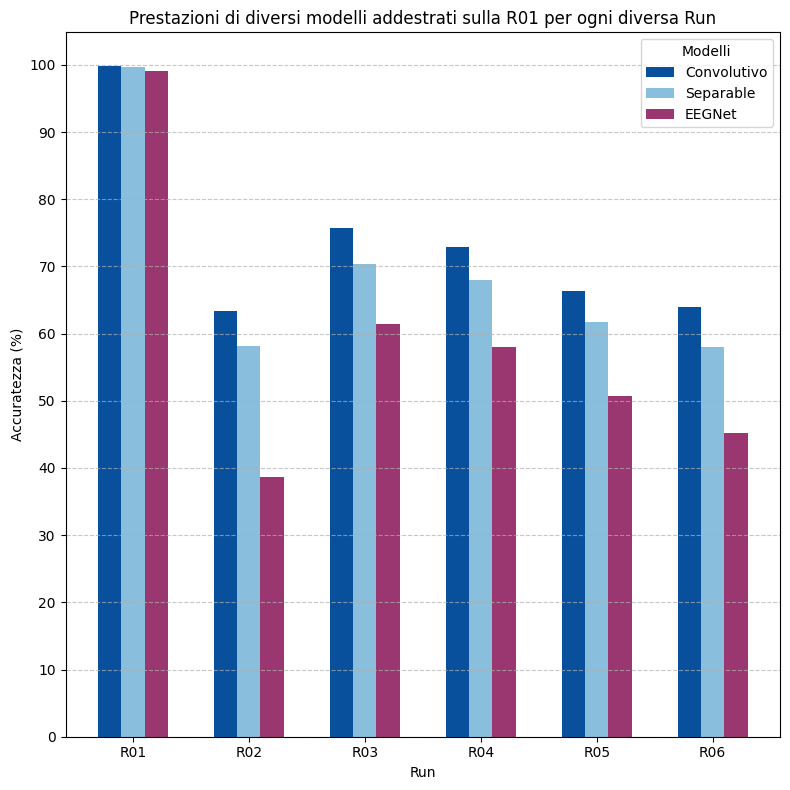

In [ ]:
#@title Capacità di generalizzazione dei vari modelli dal task 1 agli altri
# Ridefinizione delle variabili convolutivo_01, separable_01, eegnet_01
convolutivo_01 = convolutivo.iloc[0, 1:]
separable_01 = separable.iloc[0, 1:]
eegnet_01 = eegnet.iloc[0, 1:]

# Creazione del barplot con triple barre
import numpy as np
plt.figure(figsize=(8, 8))

# Indici delle colonne per posizionare le barre
x = np.arange(len(convolutivo_01.index))

# Larghezza delle barre
width = 0.2

# Creazione delle barre per ogni modello
plt.bar(x - width, convolutivo_01.values, width, label="Convolutivo", color=sns.color_palette("Blues", 7)[6])
plt.bar(x, separable_01.values, width, label="Separable", color=sns.color_palette("Blues", 6)[2])
plt.bar(x + width, eegnet_01.values, width, label="EEGNet", color=sns.color_palette("flare", 8)[5])

# Personalizzazione del grafico
plt.xticks(x, convolutivo_01.index)
plt.yticks(np.arange(0, 110, 10))  # Aumento dei tick sull'asse y
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title("Prestazioni di diversi modelli addestrati sulla R01 per ogni diversa Run")
plt.xlabel("Run")
plt.ylabel("Accuratezza (%)")

# Aggiunta della legenda
plt.legend(title="Modelli")
plt.tight_layout()
plt.show()


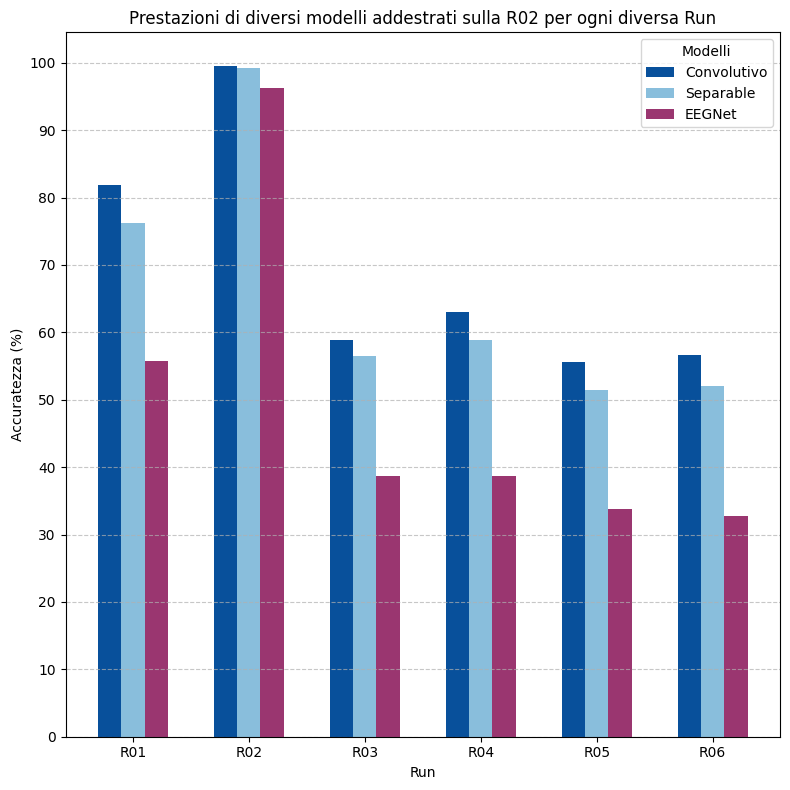

In [ ]:
#@title Capacità di generalizzazione dei vari modelli dal task 2 agli altri
# Ridefinizione delle variabili convolutivo_02, separable_02, eegnet_02
convolutivo_02 = convolutivo.iloc[1, 1:]
separable_02 = separable.iloc[1, 1:]
eegnet_02 = eegnet.iloc[1, 1:]

# Creazione del barplot con triple barre
import numpy as np
plt.figure(figsize=(8, 8))

# Indici delle colonne per posizionare le barre
x = np.arange(len(convolutivo_02.index))

# Larghezza delle barre
width = 0.2

# Creazione delle barre per ogni modello
plt.bar(x - width, convolutivo_02.values, width, label="Convolutivo", color=sns.color_palette("Blues", 7)[6])
plt.bar(x, separable_02.values, width, label="Separable", color=sns.color_palette("Blues", 6)[2])
plt.bar(x + width, eegnet_02.values, width, label="EEGNet", color=sns.color_palette("flare", 8)[5])

# Personalizzazione del grafico
plt.xticks(x, convolutivo_01.index)
plt.yticks(np.arange(0, 110, 10))  # Aumento dei tick sull'asse y
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title("Prestazioni di diversi modelli addestrati sulla R02 per ogni diversa Run")
plt.xlabel("Run")
plt.ylabel("Accuratezza (%)")

# Aggiunta della legenda
plt.legend(title="Modelli")
plt.tight_layout()
plt.show()


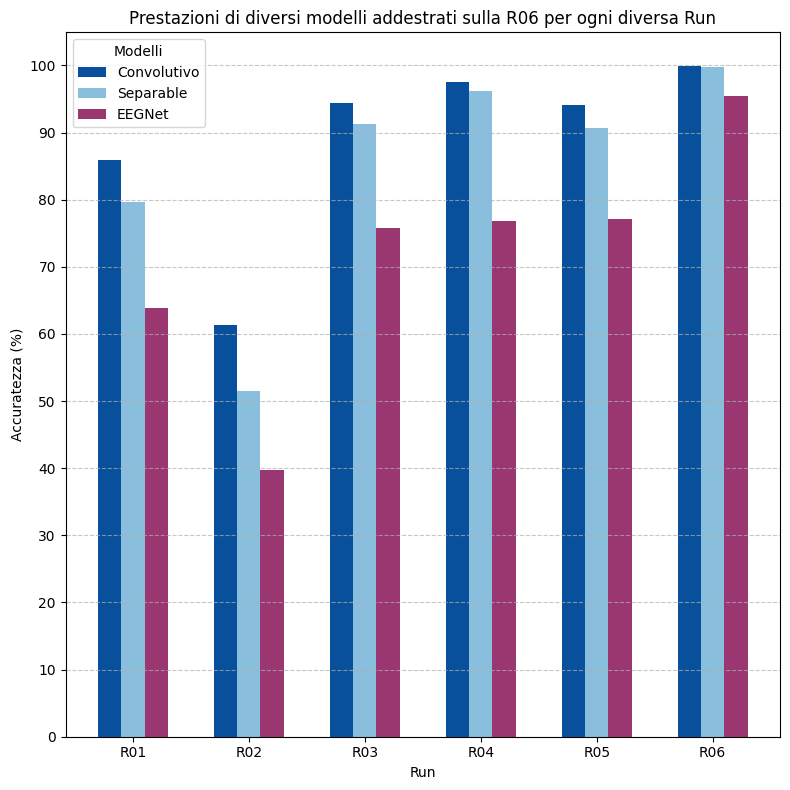

In [ ]:
#@title Capacità di generalizzazione dei vari modelli dal task 6 agli altri
# Ridefinizione delle variabili convolutivo_06, separable_06, eegnet_06
convolutivo_06 = convolutivo.iloc[2, 1:]
separable_06 = separable.iloc[2, 1:]
eegnet_06 = eegnet.iloc[2, 1:]

# Creazione del barplot con triple barre
import numpy as np
plt.figure(figsize=(8, 8))

# Indici delle colonne per posizionare le barre
x = np.arange(len(convolutivo_06.index))

# Larghezza delle barre
width = 0.2

# Creazione delle barre per ogni modello
plt.bar(x - width, convolutivo_06.values, width, label="Convolutivo", color=sns.color_palette("Blues", 7)[6])
plt.bar(x, separable_06.values, width, label="Separable", color=sns.color_palette("Blues", 6)[2])
plt.bar(x + width, eegnet_06.values, width, label="EEGNet", color=sns.color_palette("flare", 8)[5])

# Personalizzazione del grafico
plt.xticks(x, convolutivo_01.index)
plt.yticks(np.arange(0, 110, 10))  # Aumento dei tick sull'asse y
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.title("Prestazioni di diversi modelli addestrati sulla R06 per ogni diversa Run")
plt.xlabel("Run")
plt.ylabel("Accuratezza (%)")

# Aggiunta della legenda
plt.legend(title="Modelli")
plt.tight_layout()
plt.show()


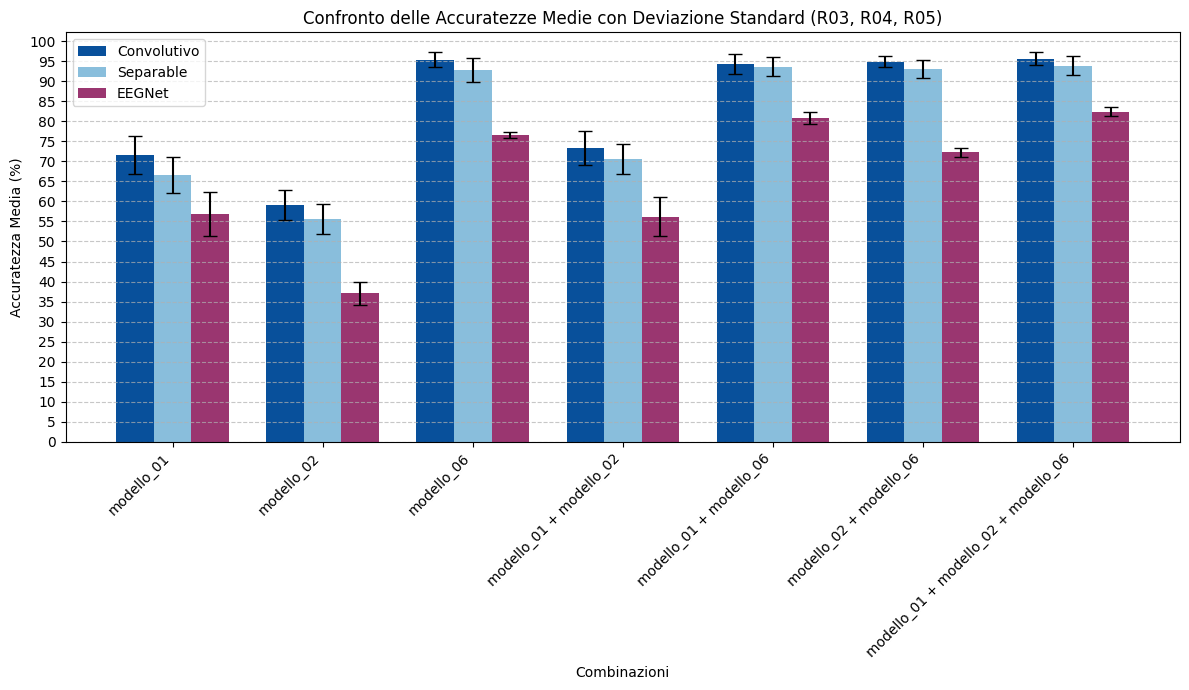

In [ ]:
#@title Confronto tra tutti i modelli utilizzati sulle capacità di generalizzazione sulle Run comuni mai viste

# Calcola la media delle colonne "R03", "R04", "R05" per ogni modello
convolutivo["Media"] = convolutivo[["R03", "R04", "R05"]].mean(axis=1)
convolutivo["Deviazione Standard"] = convolutivo[["R03", "R04", "R05"]].std(axis=1)
separable["Media"] = separable[["R03", "R04", "R05"]].mean(axis=1)
separable["Deviazione Standard"] = separable[["R03", "R04", "R05"]].std(axis=1)
eegnet["Media"] = eegnet[["R03", "R04", "R05"]].mean(axis=1)
eegnet["Deviazione Standard"] = eegnet[["R03", "R04", "R05"]].std(axis=1)


# Combina i dati in un unico DataFrame per il grafico
combined_df = pd.DataFrame({
    "Combinazioni": convolutivo["Combinazioni"],
    "Convolutivo_Media": convolutivo["Media"],
    "Convolutivo_Deviazione": convolutivo["Deviazione Standard"],
    "Separable_Media": separable["Media"],
    "Separable_Deviazione": separable["Deviazione Standard"],
    "EEGNet_Media": eegnet["Media"],
    "EEGNet_Deviazione": eegnet["Deviazione Standard"]
})


# Grafico a barre con triple barre e error bar
x = np.arange(len(combined_df))  # Posizioni delle combinazioni
width = 0.25  # Larghezza delle barre

fig, ax = plt.subplots(figsize=(12, 7))

# Aggiungi le barre per ciascun modello con error bar
bar1 = ax.bar(x - width, combined_df["Convolutivo_Media"], width,
              yerr=combined_df["Convolutivo_Deviazione"], capsize=5, label="Convolutivo", color=sns.color_palette("Blues", 7)[6])
bar2 = ax.bar(x, combined_df["Separable_Media"], width,
              yerr=combined_df["Separable_Deviazione"], capsize=5, label="Separable", color=sns.color_palette("Blues", 6)[2])
bar3 = ax.bar(x + width, combined_df["EEGNet_Media"], width,
              yerr=combined_df["EEGNet_Deviazione"], capsize=5, label="EEGNet", color=sns.color_palette("flare", 8)[5])

# Aggiungi etichette e personalizzazioni
ax.set_title("Confronto delle Accuratezze Medie con Deviazione Standard (R03, R04, R05)")
ax.set_xlabel("Combinazioni")
ax.set_ylabel("Accuratezza Media (%)")
ax.set_xticks(x)
ax.set_xticklabels(combined_df["Combinazioni"], rotation=45, ha="right")
ax.legend()

# Mostra griglia
ax.grid(axis="y", linestyle="--", alpha=0.7)
# Imposta i tick sull'asse Y ogni 5 unità
yticks = np.arange(0, 105, 5)  # Da 0 a 100 con step di 5
ax.set_yticks(yticks)

# Mostra il grafico
plt.tight_layout()
plt.show()

Dal grafico si può vedere quanto generalmente sia il modello convolutivo che separable siano migliori rispetto all'EEGNet e come unire le previsioni tramite un ensamble aiuti a migliorare le prestazioni.

---
<a name="5"></a>
# **XAI**



In questa sezione esaminiamo qualche confronto ottenuto fra le heatmap rappresentanti la rilevanza rispettivamente di ogni canale per i campioni.

---
<a name="5"></a>
# **Conclusioni e rispettive domande aperte**

## **Modelli utilizzati**
In questo lavoro, abbiamo analizzato l’efficacia di diversi modelli di reti neurali applicati alla classificazione delle persone utilizzando il dataset EEG Motor Movement Imagery, concentrandoci sulla Run01. I modelli testati includono:

*   Modello **Conv1D** con un solo strato;
*   Modello **SeparableConv1D** con un solo strato;
*   Modello **EEGNet**, una rete più complessa composta da più strati, incluse convoluzioni Conv2D e SeparableConv2D.

### **Risultati generali**
I risultati ottenuti mostrano che i modelli Conv1D e SeparableConv1D, nonostante la loro semplicità strutturale, hanno superato in termini prestazionali il modello EEGNet. Di seguito proponiamo alcune ipotesi per spiegare il comportamento osservato:


*   **Adattabilità del modello ai segnali EEG**: i dati EEG presentano una natura sequenziale e monodimensionale; pertanto, l’uso di modelli 1D risulta più appropriato per catturare le dipendenze temporali del segnale rispetto a modelli 2D, che introducono complessità non necessarie;

*   **Riduzione del rischio di overfitting**: il modello EEGNet, più profondo e con una maggiore quantità di parametri, potrebbe aver sofferto di overfitting, soprattutto considerando l’utilizzo della sola run01, limitata in termini di dati disponibili;


*   **Efficienza delle Convoluzioni Separabili**: il modello SeparableConv1D ha mostrato prestazioni competitive grazie alla separazione della convoluzione in due fasi (depthwise e pointwise). Questa tecnica riduce significativamente il numero di parametri senza compromettere la capacità di catturare le dipendenze locali, particolarmente rilevanti per i segnali EEG;

*   **Scelta della tecnica di pooling**: l’impiego della Global Average Pooling (GAP) al posto della Max Pooling ha probabilmente fornito un ulteriore beneficio, preservando l’informazione globale del segnale in fase di aggregazione. La Max Pooling, infatti, tende a perdere dettagli significativi, che risultano particolarmente critici nell’analisi dei segnali EEG.


---
## **Capacità di Generalizzazione**

Un aspetto cruciale della nostra analisi riguarda la **capacità di generalizzazione** dei modelli addestrati. Abbiamo osservato che, addestrando i modelli su una singola **run**, i risultati ottenuti sono buoni quando i modelli vengono testati sulla medesima run.

Tuttavia, la situazione cambia significativamente quando testiamo i modelli su **task differenti** rispetto a quelli utilizzati in fase di addestramento. In particolare:  

- I modelli addestrati sulla **run 1** o sulla **run 2** non mostrano buone prestazioni quando testati su task differenti.  
- Al contrario, i modelli addestrati sulla **run 6** hanno dimostrato una capacità di generalizzazione migliore, ottenendo buoni risultati sulle **run 3, 4 e 5**, discreti sulla **run 1** e non sufficienti sulla **run 2**.  

### **Ipotesi sulle Differenze nei Task EEG**  
Riteniamo che questa difficoltà di generalizzazione sia strettamente legata alla **natura dei task** sperimentali, che differiscono significativamente in termini di attività cognitiva richiesta e nei pattern EEG generati:  

1. **Task 1**: Basale, occhi aperti  
2. **Task 2**: Basale, occhi chiusi  
3. **Task 3**: Chiusura del pugno destro o sinistro  
4. **Task 4**: Immaginare la chiusura del pugno destro o sinistro  
5. **Task 5**: Chiusura simultanea di entrambi i pugni o dei piedi  
6. **Task 6**: Immaginare la chiusura simultanea di entrambi i pugni o dei piedi  

I **task basali** (1 e 2) presentano segnali EEG più omogenei e meno complessi, in quanto l'attività cerebrale è meno specifica e più generalizzata. Al contrario, i **task motori reali** (3 e 5) e quelli di **immaginazione motoria** (4 e 6) richiedono un'attivazione cerebrale più specifica e localizzata. In particolare quindi, il **task 6** sembra generare pattern EEG più ricchi e complessi rispetto ai **task basali**, favorendo una migliore generalizzazione su altri task motori e di immaginazione.

### **Miglioramento con Ensemble**  
Un ulteriore miglioramento è stato ottenuto combinando i modelli in un **ensemble**. Considerando la durata doppia di campioni per la **run 06** abbiamo assegnato i seguenti pesi:  
- **peso 1** al modello addestrato sulla **run 1**  
- **peso 1** al modello addestrato sulla **run 2**  
- **peso 2** al modello addestrato sulla **run 6**  

Questa combinazione ha permesso di migliorare complessivamente la capacità di generalizzazione. Riteniamo che ciò sia dovuto al fatto che ciascun **task mentale** genera pattern EEG **specifici**, difficilmente trasferibili da un task all'altro. Di conseguenza, un ensemble che combina informazioni apprese da più task riesce a catturare una **gamma più ampia di pattern** presenti nei segnali EEG.

### **Prestazioni di EEGNet**  
Anche in questo contesto, il modello **EEGNet** si è dimostrato meno efficace nella capacità di generalizzazione. Questo risultato potrebbe essere attribuito alla maggiore complessità del modello, che tende ad adattarsi eccessivamente ai pattern specifici del task di addestramento, a scapito della sua capacità di generalizzare su task diversi.

---

## **Analisi XAI e Interpretabilità tramite Grad-CAM**

Per esplorare l’**interpretabilità** dei modelli sviluppati, abbiamo adottato tecniche di **Explainable AI (XAI)** utilizzando matrici **Grad-CAM**. Grazie alla libreria **MNE**, è stato poi possibile visualizzare le mappe 2D dello **scalpo**, evidenziando meglio i canali EEG che hanno avuto maggiore rilevanza per la classificazione di un determinato campione.  

### **Osservazioni sulle Matrici Temporali e la Rilevanza dei Canali**  
Analizzando le **matrici di input** con dimensione (64, 240) (dove 64 rappresenta i **canali** e 240 i **batch temporali** corrispondenti a 1,5 secondi), abbiamo osservato quanto segue:  
- Tutto il **campione temporale** viene utilizzato, con una distribuzione intermittente della rilevanza dei canali lungo il **tempo**. Questo suggerisce che il segnale EEG non presenta una concentrazione della rilevanza in una singola parte temporale (ad esempio, all’inizio o alla fine del campione).  
- L'attivazione intermittente dei canali evidenzia che i modelli considerano più **fasi temporali** nel segnale EEG, piuttosto che affidarsi a una porzione limitata del campione.

### **Differenze tra Volontari e Pattern dei Canali**  
Utilizzando le mappe 2D facendo la media per canali dei 240 valori di rilevanza, abbiamo osservato che:  
- I **canali maggiormente rilevanti** variano **da volontario a volontario**, indicando una **specificità individuale** nei pattern EEG utilizzati da uno specifico modello.  
- Al contrario, per campioni diversi appartenenti allo **stesso volontario**, i **canali rilevanti** rimangono costanti, suggerendo una certa **consistenza interna** del modello per singoli soggetti.  

### **Differenze tra Modelli**  
Un’ulteriore analisi è stata svolta confrontando l’utilizzo dei canali per lo **stesso volontario**, ma con **modelli differenti**. In questo caso, abbiamo riscontrato:  
- Una **variabilità significativa** nei pattern di rilevanza dei canali, con modelli diversi che enfatizzano aree dello scalpo differenti per uno stesso campione.  

### **Ipotesi e Valutazioni**  
Questi risultati suggeriscono che:  
- Non emerge un **pattern specifico** universale che possa identificare una persona a partire dai segnali EEG. La rilevanza dei canali sembra dipendere sia dal **modello** utilizzato, sia dalle **caratteristiche individuali** del soggetto.  
- Questo comportamento potrebbe essere attribuibile alla **complessità intrinseca** dei segnali EEG e alla loro elevata variabilità inter-soggetto. La natura del segnale EEG, combinata con le caratteristiche dei modelli di rete neurale, tende quindi a comportarsi come una **“black box”**, rendendo difficile individuare pattern interpretabili e generalizzabili.


---

## **Conclusioni**

Alla luce delle nostre osservazioni, possiamo trarre le seguenti conclusioni:  
1. **Specificità dei Task Mentali**: Ogni **task mentale o fisico** produce segnali EEG differenti e richiede un **addestramento specifico**. I segnali EEG non generalizzano facilmente tra task diversi, e ciò è confermato sia dalle prestazioni dei modelli sia dall’analisi dei pattern nei canali EEG.  
2. **Variabilità Individuale e Modello-Dipendente**: L'interpretabilità delle reti tramite **Grad-CAM** evidenzia una forte **variabilità inter-soggetto** e una dipendenza significativa dal modello utilizzato. Non è possibile individuare un **pattern di attivazione stabile** per l’identificazione di un soggetto.  
3. **Applicazione nel Mondo Reale**: Per una possibile implementazione pratica, come la **classificazione di un soggetto per l’accesso a un sistema**, sarebbe necessario **predefinire un task mentale o fisico** specifico. Questo approccio ridurrebbe la variabilità dei segnali EEG e permetterebbe di costruire modelli più robusti e accurati.  

### **Prospettive Future**  
Per migliorare l’identificazione tramite segnali EEG, riteniamo che siano necessarie ulteriori analisi e sviluppi, tra cui:  
- **Selezione dei task**: Individuare task mentali o fisici che producano segnali EEG più stabili e distintivi tra i soggetti.  
- **Ottimizzazione dei modelli**: Utilizzare tecniche avanzate di **regolarizzazione** e di **ensemble learning** per combinare le informazioni apprese da più task e migliorare la generalizzazione.  
- **Analisi approfondita delle feature**: Sviluppare metodi per identificare feature EEG più interpretabili e stabili nel tempo.